In [45]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
# Définition du modèle CNN
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()

        # Couches de convolution
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 7)  # 7 émotions
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [48]:
# Définition du Dataset
class EmotionDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
        self.images = []
        self.labels = []

        for class_idx, emotion in enumerate(self.classes):
            class_dir = os.path.join(data_dir, emotion)
            for img_name in os.listdir(class_dir):
                self.images.append(os.path.join(class_dir, img_name))
                self.labels.append(class_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('L')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [49]:
# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation de : {device}")

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
])

Utilisation de : cpu


In [50]:
transform_train = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])
# Chargement des données
train_dataset = EmotionDataset("archive/train", transform=transform)
test_dataset = EmotionDataset("archive/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [52]:
# Fonction d'évaluation du modele
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, all_predictions, all_labels

In [64]:
model = EmotionCNN().to(device)
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss comme fonction de perte
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [65]:
# Entraînement du modele
num_epochs = 20
best_accuracy = 0
best_model_state = None

# Ajout de listes pour suivre les métriques
train_accuracies = []
test_accuracies = []
epoch_losses = []

for epoch in range(num_epochs):
    # Mode entraînement
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0
    train_correct = 0
    train_total = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()

        # Calcul de l'accuracy d'entraînement
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        if (i + 1) % 100 == 0:
            train_accuracy = 100 * train_correct / train_total
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}]')
            print(f'Loss: {running_loss/100:.4f}, Train Accuracy: {train_accuracy:.2f}%')
            running_loss = 0.0

    # Calcul de l'accuracy finale pour cette epoch
    final_train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(final_train_accuracy)
    epoch_losses.append(epoch_loss / len(train_loader))

    # Évaluation sur le test set
    test_accuracy, predictions, true_labels = evaluate_model(model, test_loader)
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Accuracy: {final_train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

    # Sauvegarde du meilleur modèle
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model_state = model.state_dict()
        print(f'Nouveau meilleur modèle sauvegardé avec accuracy: {best_accuracy:.2f}%')


Epoch [1/20], Step [100/898]
Loss: 1.8265, Train Accuracy: 24.78%
Epoch [1/20], Step [200/898]
Loss: 1.7933, Train Accuracy: 25.34%
Epoch [1/20], Step [300/898]
Loss: 1.7446, Train Accuracy: 26.64%
Epoch [1/20], Step [400/898]
Loss: 1.6364, Train Accuracy: 28.84%
Epoch [1/20], Step [500/898]
Loss: 1.6287, Train Accuracy: 30.47%
Epoch [1/20], Step [600/898]
Loss: 1.5511, Train Accuracy: 31.99%
Epoch [1/20], Step [700/898]
Loss: 1.5123, Train Accuracy: 33.25%
Epoch [1/20], Step [800/898]
Loss: 1.4884, Train Accuracy: 34.53%
Epoch [1/20] - Train Accuracy: 35.37%, Test Accuracy: 43.23%
Nouveau meilleur modèle sauvegardé avec accuracy: 43.23%
Epoch [2/20], Step [100/898]
Loss: 1.4438, Train Accuracy: 43.69%
Epoch [2/20], Step [200/898]
Loss: 1.4362, Train Accuracy: 44.27%
Epoch [2/20], Step [300/898]
Loss: 1.4200, Train Accuracy: 44.64%
Epoch [2/20], Step [400/898]
Loss: 1.4081, Train Accuracy: 45.06%
Epoch [2/20], Step [500/898]
Loss: 1.4050, Train Accuracy: 45.41%
Epoch [2/20], Step [600/

In [67]:
# Sauvegarde du meilleur modèle
model_info = {
    'model_state_dict': best_model_state,
    'classes': train_dataset.classes,
    'input_size': 48,
    'best_accuracy': best_accuracy
}

torch.save(model_info, 'best_emotion_model.pth')
print(f"Meilleur modèle sauvegardé avec accuracy finale: {best_accuracy:.2f}%")

Meilleur modèle sauvegardé avec accuracy finale: 55.87%


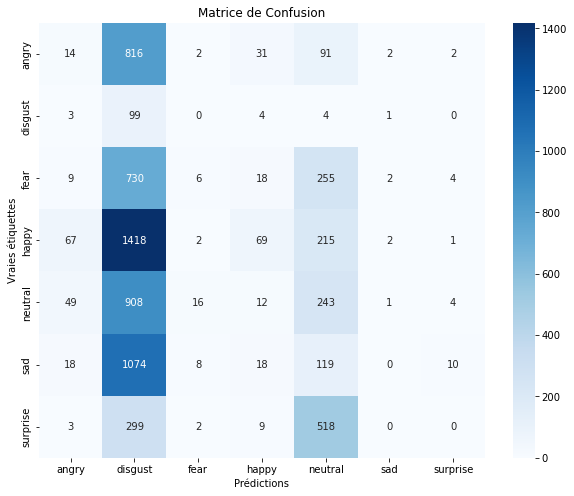

In [68]:
# Visualisation de la matrice de confusion
def plot_confusion_matrix(true_labels, predictions, classes):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Matrice de Confusion')
    plt.ylabel('Vraies étiquettes')
    plt.xlabel('Prédictions')
    plt.show()

# Évaluation finale et affichage de la matrice de confusion
final_accuracy, final_predictions, final_true_labels = evaluate_model(model, test_loader)
plot_confusion_matrix(final_true_labels, final_predictions, train_dataset.classes)

In [69]:
import torch
from PIL import Image
from torchvision import transforms

# Charger le modèle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_info = torch.load('best_emotion_model.pth')
model = EmotionCNN().to(device)
model.load_state_dict(model_info['model_state_dict'])
model.eval()
classes = model_info['classes']

# Fonction pour prédire l'émotion sur une image
def predict_emotion(image_path):
    image = Image.open(image_path).convert('L')

    # Prétraiter l'image
    transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Prédire l'émotion
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)[0]

    emotion = classes[predicted.item()]
    confidence = probs[predicted.item()].item()

    return f"Émotion détectée: {emotion} avec une confiance de {confidence:.2f}"

# Test avec une image
image_path = "/Users/barrysalam/Desktop/hackathon-ipssi-mia-web/models/archive/train/sad/Training_99996831.jpg" 
result = predict_emotion(image_path)
print(result)

Émotion détectée: sad avec une confiance de 0.96


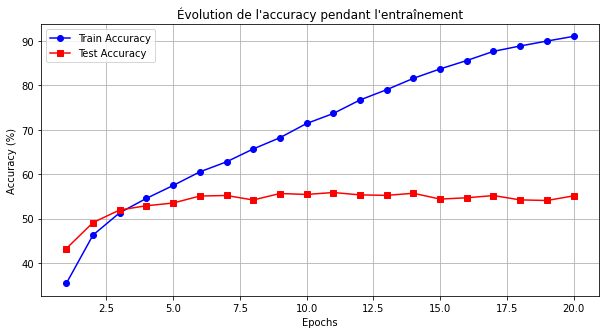

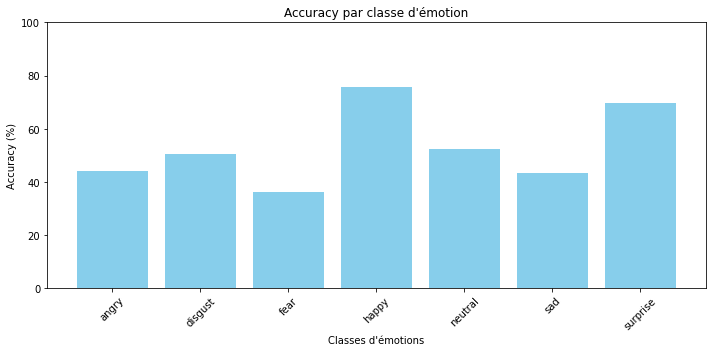

In [70]:

plt.figure(figsize=(10, 5))

# Graphique de l'accuracy
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'b-', marker='o', label='Train Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, 'r-', marker='s', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Évolution de l\'accuracy pendant l\'entraînement')
plt.legend()
plt.grid(True)
plt.show()


class_correct = [0] * len(train_dataset.classes)
class_total = [0] * len(train_dataset.classes)

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


class_accuracy = [100 * correct / total for correct, total in zip(class_correct, class_total)]

# Création du graphique
plt.figure(figsize=(10, 5))
plt.bar(train_dataset.classes, class_accuracy, color='skyblue')
plt.xlabel('Classes d\'émotions')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy par classe d\'émotion')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()